### Importing the necessary libraries

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

### Loading the data and plotting visualizations

In [17]:
df = pd.read_csv("../data/heart.csv")

# Splitting the data into input and target
X = df.drop('output', axis=1)
Y = df['output']

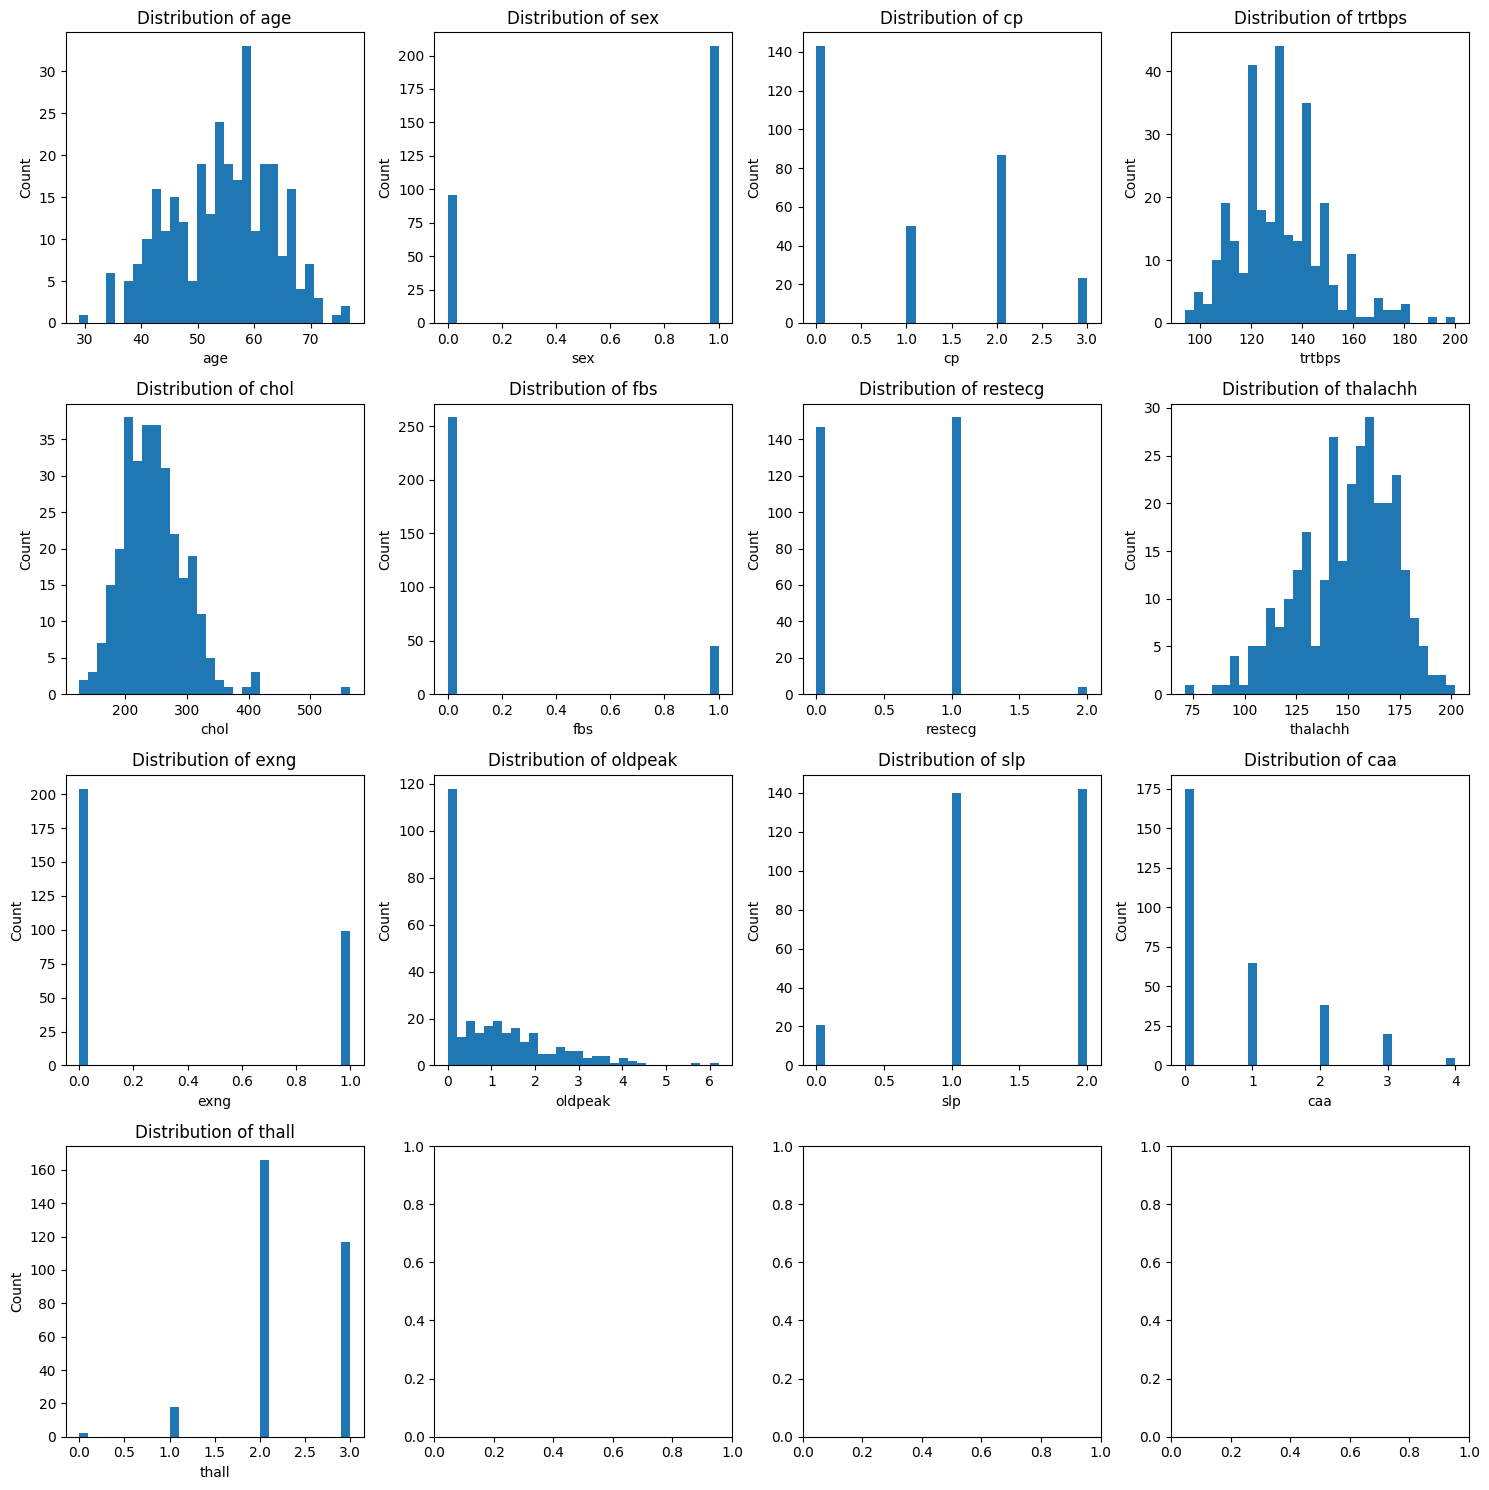

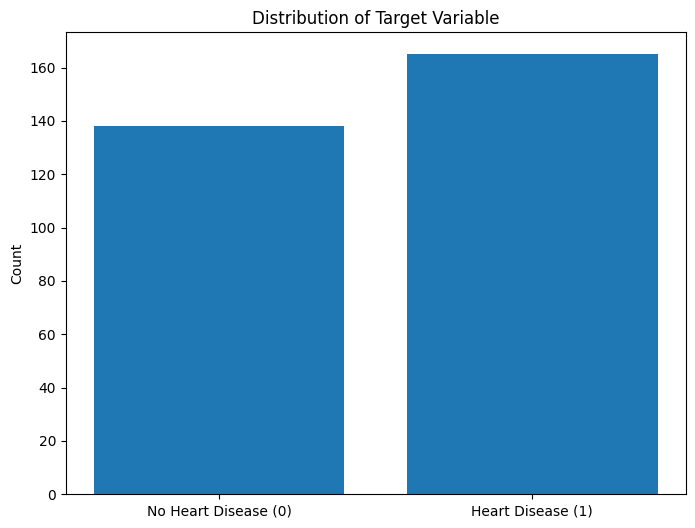

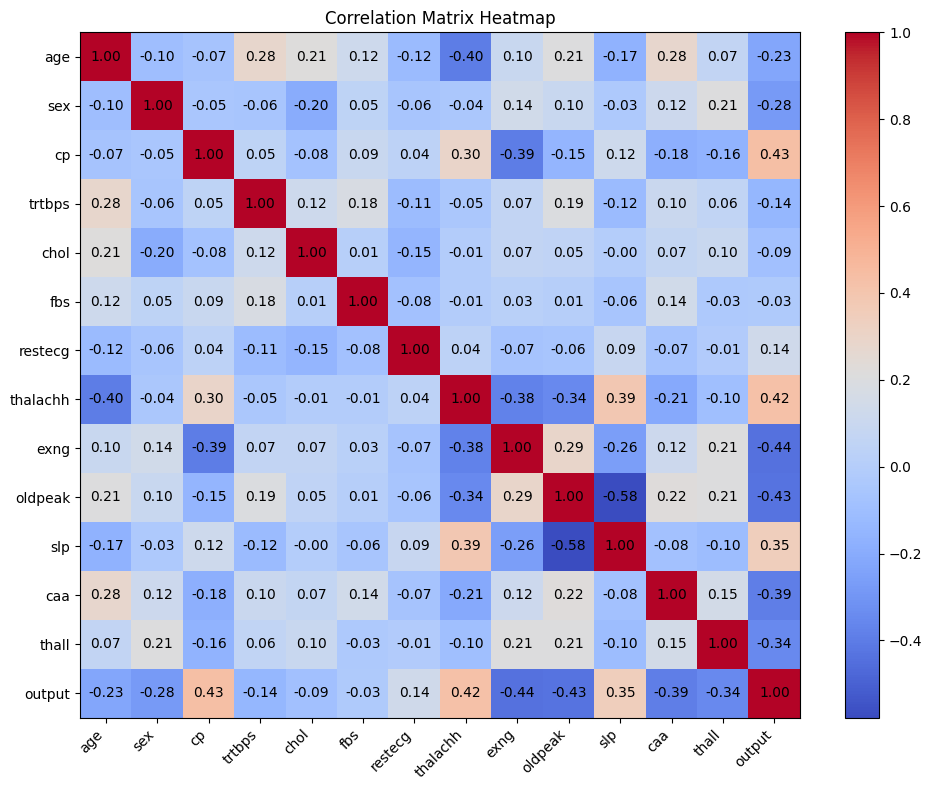

In [18]:
# Plotting the distribution of each feature
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.ravel()

for idx, col in enumerate(X.columns):
    axes[idx].hist(X[col], bins=30)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Plotting the distribution of the target variable
plt.figure(figsize=(8, 6))
plt.bar(['No Heart Disease (0)', 'Heart Disease (1)'], Y.value_counts().sort_index())
plt.title('Distribution of Target Variable')
plt.ylabel('Count')
plt.show()

# Plotting the correlation matrix heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix Heatmap')
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                ha='center', va='center', color='black')
plt.tight_layout()
plt.show()

### Building the Neural Network


In [124]:
class NeuralNetwork:
    '''
    A class for building and training a neural network.

    Attributes:
        layer_dims (list): A list of integers representing the number of neurons in each layer.
        activations (list): A list of strings representing the activation function for each layer.
        learning_rate (float): The learning rate for the optimizer.
        decay (float): The decay rate for the learning rate.
        epochs (int): The number of epochs to train the model.
        batch_size (int): The batch size for training.
        dropout_rate (float): The dropout rate for the model.
        regularization (str): The regularization method for the model.
        reg_lambda (float): The regularization parameter for the model.
        grad_clip (float): The gradient clipping parameter for the model.
        seed (int): The random seed for reproducibility.
    '''	
    def __init__(
        self,
        layer_dims,
        activations,
        learning_rate=0.001,
        decay=0.001,
        epochs=1000,
        batch_size=32,
        dropout_rate=0.1,
        regularization=None,
        reg_lambda=0.01,
        grad_clip=1.0,
        seed=42
    ):
        self.layer_dims = layer_dims
        self.activations = activations
        self.learning_rate = learning_rate
        self.decay = decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.regularization = regularization
        self.reg_lambda = reg_lambda
        self.grad_clip = grad_clip
        self.set_seed(seed)
        self.params = self._initialize_parameters()
        
    def set_seed(self, seed):
        '''
        Sets random seed for reproducibility.

        Args:
            seed (int): Random seed value
        '''
        np.random.seed(seed)

    def _initialize_parameters(self):
        '''
        Initializes the parameters (weights and biases) of the neural network.
        Uses He initialization for weights and zeros for biases.

        Returns:
            parameters (dict): The initialized parameters of the neural network.
        '''
        parameters = {}
        
        for l in range(1, len(self.layer_dims)):
            parameters[f'W{l}'] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1]) * np.sqrt(2/self.layer_dims[l-1])
            parameters[f'b{l}'] = np.zeros((self.layer_dims[l], 1))
            
        return parameters

    def _activation_forward(self, Z, activation):
        '''
        Applies the activation function to the input.

        Args:
            Z (np.array): The input to the activation function.
            activation (str): The activation function to apply.

        Returns:
            A (np.array): The output of the activation function.
        '''	
        if activation == "relu":
            return np.maximum(0, Z)
        elif activation == "leaky_relu":
            return np.where(Z > 0, Z, 0.01 * Z)
        elif activation == "sigmoid":
            return 1 / (1 + np.exp(-Z))
        elif activation == "tanh":
            return np.tanh(Z)
        elif activation == "elu":
            return np.where(Z > 0, Z, 0.1 * (np.exp(Z) - 1))

    def _activation_backward(self, dA, Z, activation):
        '''
        Computes the backward pass of the activation function.

        Args:
            dA (np.array): The derivative of the activation function.
            Z (np.array): The input to the activation function.
            activation (str): The activation function to apply.

        Returns:
            dZ (np.array): The derivative of the activation function.
        '''		
        if activation == "relu":
            dZ = np.array(dA, copy=True)
            dZ[Z <= 0] = 0
            return dZ
        elif activation == "leaky_relu":
            dZ = np.where(Z > 0, dA, dA * 0.01)
            return dZ
        elif activation == "sigmoid":
            s = 1 / (1 + np.exp(-Z))
            return dA * s * (1 - s)
        elif activation == "tanh":
            t = np.tanh(Z)
            return dA * (1 - t ** 2)
        elif activation == "elu":
            dZ = np.where(Z > 0, dA, dA * (Z + 0.1))
            return dZ

    def _batch_norm(self, A, layer_index):
        '''
        Applies batch normalization to the input.

        Args:
            A (np.array): The input to the batch normalization.
            layer_index (int): The index of the layer to apply batch normalization to.

        Returns:
            A_out (np.array): The output of the batch normalization.
        '''
        mean = np.mean(A, axis=1, keepdims=True)
        variance = np.var(A, axis=1, keepdims=True)
        A_norm = (A - mean) / np.sqrt(variance + 1e-8)
        
        if f'gamma{layer_index}' not in self.params:
            self.params[f'gamma{layer_index}'] = np.ones((A.shape[0], 1))
            self.params[f'beta{layer_index}'] = np.zeros((A.shape[0], 1))
        
        A_out = self.params[f'gamma{layer_index}'] * A_norm + self.params[f'beta{layer_index}']
        return A_out 

    def _forward(self, X):
        '''
        Performs the forward pass of the neural network.

        Args:
            X (np.array): The input to the neural network.

        Returns:
            A_last (np.array): The output of the neural network.
        '''
        cache = {'A0': X}

        for i in range(1, len(self.layer_dims)):
            W = self.params[f'W{i}']
            b = self.params[f'b{i}']
            A_prev = cache[f'A{i-1}']
            Z = np.dot(W, A_prev) + b

            A = self._activation_forward(Z, self.activations[i-1])
            if i < len(self.layer_dims) - 1:
                A = self._batch_norm(A, i)
            
            if i < len(self.layer_dims) - 1 and self.dropout_rate > 0:
                dropout_mask = np.random.rand(*A.shape) > self.dropout_rate
                A *= dropout_mask / (1 - self.dropout_rate)
                cache[f'D{i}'] = dropout_mask

            cache[f'Z{i}'] = Z
            cache[f'A{i}'] = A

        return cache[f'A{len(self.layer_dims) - 1}'], cache


    def _backward(self, A_last, Y, cache):
        '''
        Performs the backward pass of the neural network.

        Args:
            A_last (np.array): The output of the neural network.
            Y (np.array): The target values.
            cache (dict): The cache of the forward pass.

        Returns:
            grads (dict): The gradients of the neural network.
        '''
        m = A_last.shape[1]
        grads = {}
        dA_prev = A_last - Y

        for i in range(len(self.layer_dims) - 1, 0, -1):
            A_prev = cache[f'A{i-1}']
            Z = cache[f'Z{i}']
            W = self.params[f'W{i}']

            dZ = self._activation_backward(dA_prev, Z, self.activations[i-1])
            grads[f'dW{i}'] = (1 / m) * np.dot(dZ, A_prev.T)
            grads[f'db{i}'] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
            dA_prev = np.dot(W.T, dZ)

            if self.regularization == "L2":
                grads[f'dW{i}'] += (self.reg_lambda / m) * W

            # Gradient clipping
            grads[f'dW{i}'] = np.clip(grads[f'dW{i}'], -self.grad_clip, self.grad_clip)
            grads[f'db{i}'] = np.clip(grads[f'db{i}'], -self.grad_clip, self.grad_clip)

        return grads

    def _update_params(self, grads):
        '''
        Updates the parameters of the neural network.

        Args:
            grads (dict): The gradients of the neural network.
        '''
        for i in range(1, len(self.layer_dims)):
            self.params[f'W{i}'] -= self.learning_rate * grads[f'dW{i}']
            self.params[f'b{i}'] -= self.learning_rate * grads[f'db{i}']

    def compute_loss(self, Y, A_last, class_weights={0: 1.0, 1: 1.8}):
        '''
        Computes the loss of the neural network.

        Args:
            Y (np.array): The target values.
            A_last (np.array): The output of the neural network.
            class_weights (dict): The class weights for the loss function.

        Returns:
            loss (float): The loss of the neural network.
        '''
        m = Y.shape[1]
        loss = -(class_weights[1] * Y * np.log(A_last + 1e-8) + class_weights[0] * (1 - Y) * np.log(1 - A_last + 1e-8))
        return np.sum(loss) / m

    def train(self, X, Y, X_val=None, Y_val=None, print_every=100):
        '''
        Trains the neural network.

        Args:
            X (np.array): The input to the neural network.
            Y (np.array): The target values.
            X_val (np.array): The validation input.
            Y_val (np.array): The validation target values.
            print_every (int): The number of epochs to print the loss.
        '''
        initial_learning_rate = self.learning_rate
        losses = []
        val_losses = []

        class_weights = compute_class_weight('balanced', classes=np.unique(Y.flatten()), y=Y.flatten())
        class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

        for epoch in range(self.epochs):
            self.learning_rate = initial_learning_rate * np.exp(-self.decay * epoch)
            A_last, cache = self._forward(X)
            loss = self.compute_loss(Y, A_last, class_weight_dict)
            losses.append(loss)

            if X_val is not None and Y_val is not None:
                A_val, _ = self._forward(X_val)
                val_loss = self.compute_loss(Y_val, A_val, class_weight_dict)
                val_losses.append(val_loss)

            if epoch % print_every == 0:
                print(f"Epoch {epoch}, Training Loss: {loss:.4f}")
                if X_val is not None and Y_val is not None:
                    print(f"Validation Loss: {val_loss:.4f}")

            grads = self._backward(A_last, Y, cache)
            self._update_params(grads)
        
        self.plot_loss(losses, X_val, Y_val, val_losses)

    def plot_loss(self, losses, X_val=None, Y_val=None, val_losses=None):
        '''
        Plots the loss curve of the neural network.

        Args:
            losses (list): The losses of the neural network.
        '''
        plt.plot(losses, label="Training Loss")
        if X_val is not None and Y_val is not None:
            plt.plot(val_losses, label="Validation Loss")
        plt.title("Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()


    def predict(self, X):
        '''
        Predicts the target values of the neural network.

        Args:
            X (np.array): The input to the neural network.

        Returns:
            predictions (np.array): The predictions of the neural network.
        '''
        A_last, _ = self._forward(X)
        return (A_last > 0.5).astype(int)

### Training the Neural Network and evaluating the performance

Epoch 0, Training Loss: 0.8220
Validation Loss: 0.7866
Epoch 500, Training Loss: 0.6739
Validation Loss: 0.7468
Epoch 1000, Training Loss: 0.5648
Validation Loss: 0.5751
Epoch 1500, Training Loss: 0.5179
Validation Loss: 0.5694
Epoch 2000, Training Loss: 0.5066
Validation Loss: 0.5348
Epoch 2500, Training Loss: 0.4449
Validation Loss: 0.5114


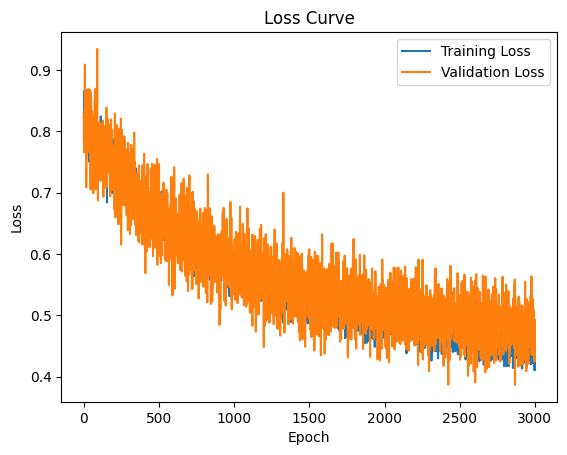

In [125]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train_binary = y_train.to_numpy().reshape(1, -1)
y_test_binary = y_test.to_numpy().reshape(1, -1)

# Building the Neural Network
nn = NeuralNetwork(
    layer_dims=[X_train.shape[1], 512, 256, 128, 1],
    activations=['relu', 'relu', 'relu', 'sigmoid'],
    learning_rate=0.0005,
    decay=0.0001,
    epochs=3000,
    dropout_rate=0.05,
    regularization="L2",
    reg_lambda=0.005,
    batch_size=32,
    seed=1500
)

# Training the Neural Network
nn.train(X_train.T, y_train_binary, X_val=X_test.T, Y_val=y_test_binary, print_every=500)

In [136]:
np.random.seed(55551)

# Making predictions and calculating accuracies
train_predictions = nn.predict(X_train.T)
test_predictions = nn.predict(X_test.T)

train_accuracy = np.mean(train_predictions == y_train_binary.flatten())
test_accuracy = np.mean(test_predictions == y_test_binary.flatten())

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.8182
Testing Accuracy: 0.8361


### Training the KNN model and evaluating the performance

In [137]:
from collections import Counter

class KNN:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict(self, X):
        predictions = [self._predict_single(x) for x in X]
        return np.array(predictions)

    def _predict_single(self, x):
        distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        
        k_indices = np.argsort(distances)[:self.k]
        
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


In [169]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.2, random_state=42)

# Initialize the KNN model
knn = KNN(k=11)

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = knn.score(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 75.41%
